# my_alps (Digital Elevation Model GAN)

Train a 1D DCGAN based on StyleGAN (https://arxiv.org/abs/1812.04948) on 2D heightmaps from the **ASTER Global Digital Elevation Model V003** (https://www.earthdata.nasa.gov/) following the basic TensorFlow DCGAN tutorial (https://www.tensorflow.org/tutorials/generative/dcgan).

Heightmap dataset: Alps (N44E006-N48E015).

### Get & prepare the data

In [1]:
# download data and move to raw_data folder
#!chmod 777 download.sh
#!./download.sh
#!mv ASTG* drive/MyDrive/my_alps/data_v1
#!pip install --user imageio

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image

In [4]:
# collect all DEM imagery
data_path = "data_v1/"
filelist = []
for file in os.listdir(data_path):
  if file.endswith("dem.tif"):
    filename = os.path.join(data_path, file)
    filelist.append(filename)
print(filelist)

['data_v1/ASTGTMV003_N44E006_dem.tif', 'data_v1/ASTGTMV003_N44E007_dem.tif', 'data_v1/ASTGTMV003_N45E005_dem.tif', 'data_v1/ASTGTMV003_N45E006_dem.tif', 'data_v1/ASTGTMV003_N45E007_dem.tif', 'data_v1/ASTGTMV003_N45E008_dem.tif', 'data_v1/ASTGTMV003_N45E009_dem.tif', 'data_v1/ASTGTMV003_N45E010_dem.tif', 'data_v1/ASTGTMV003_N45E011_dem.tif', 'data_v1/ASTGTMV003_N45E012_dem.tif', 'data_v1/ASTGTMV003_N46E005_dem.tif', 'data_v1/ASTGTMV003_N46E006_dem.tif', 'data_v1/ASTGTMV003_N46E007_dem.tif', 'data_v1/ASTGTMV003_N46E008_dem.tif', 'data_v1/ASTGTMV003_N46E009_dem.tif', 'data_v1/ASTGTMV003_N46E010_dem.tif', 'data_v1/ASTGTMV003_N46E011_dem.tif', 'data_v1/ASTGTMV003_N46E012_dem.tif', 'data_v1/ASTGTMV003_N46E013_dem.tif', 'data_v1/ASTGTMV003_N46E014_dem.tif', 'data_v1/ASTGTMV003_N47E007_dem.tif', 'data_v1/ASTGTMV003_N47E008_dem.tif', 'data_v1/ASTGTMV003_N47E009_dem.tif', 'data_v1/ASTGTMV003_N47E010_dem.tif', 'data_v1/ASTGTMV003_N47E011_dem.tif', 'data_v1/ASTGTMV003_N47E012_dem.tif', 'data_v1/AS

In [5]:
# convert to 4D-tensor
img_data = np.array([np.array(imageio.v2.imread(fname)) for fname in filelist])
images = tf.expand_dims(tf.convert_to_tensor(img_data, dtype=tf.float32), -1)
images.shape
                    
# Normalize by value spread (metres)
max_height = tf.reduce_max(images)
min_height = tf.reduce_min(images)
images = (images - min_height) / (max_height - min_height)

C:\Users\Erik\AppData\Roaming\Python\Python39\site-packages\imageio\plugins\_tifffile.py:8778: UserWarning: unexpected end of LZW stream (code 0)
  warnings.warn("unexpected end of LZW stream (code %i)" % code)
C:\Users\Erik\AppData\Roaming\Python\Python39\site-packages\imageio\plugins\_tifffile.py:3673: UserWarning: invalid tile data
  warnings.warn("invalid tile data")
C:\Users\Erik\AppData\Roaming\Python\Python39\site-packages\imageio\plugins\_tifffile.py:8778: UserWarning: unexpected end of LZW stream (code 514)
  warnings.warn("unexpected end of LZW stream (code %i)" % code)


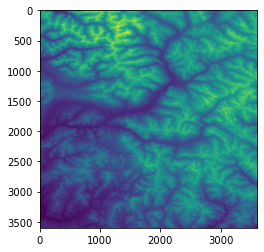

In [6]:
# plot the first image
plt.imshow(images[0]);

In [7]:
# Extract 256x256 pixel subtiles from dataset
def tile_image(images, sz):
  """
  Tile an input image into smaller subtiles of a given size.
  """

  tiles = tf.image.extract_patches(images=images,
                                   sizes=[1, sz[0], sz[1], 1],
                                   strides=[1, sz[0], sz[1], 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')
  return tiles

In [8]:
# target image size
IM_SIZE = (256, 256)

# get tiles
tiles = tile_image(images, IM_SIZE)
tf.reduce_max(tiles), tf.reduce_min(tiles)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

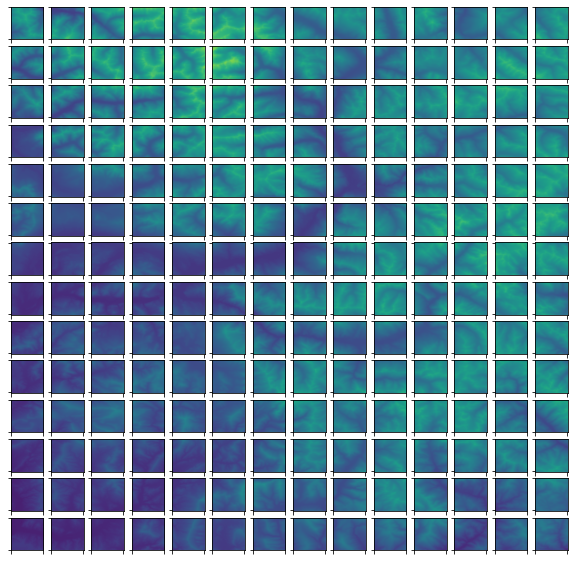

TensorShape([6664, 256, 256, 1])

In [9]:
# reshape tiles
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
count = 0
resized_tiles = []
for idx, tile in enumerate(tiles):
  for r in range(tiles.shape[1]):
    for c in range(tiles.shape[2]):
      img = tf.reshape(tiles[idx,r,c],shape=IM_SIZE)
      resized_tiles.append(img - tf.reduce_min(img))
      if idx == 0:
        ax = plt.subplot(14, 14, count+1)
        plt.imshow(img.numpy().astype("float32"),
                  vmin=0.,
                  vmax=1.)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        count += 1
plt.show();

# stack tensors to final set of images
resized_tiles = tf.stack(resized_tiles, axis=0)

# expand dimensions
full_data = tf.expand_dims(resized_tiles, axis=-1)
full_data.shape

## GAN tutorial follow-along

https://www.tensorflow.org/tutorials/generative/dcgan

In [10]:
# To generate GIFs
#!pip install imageio
#!pip install git+https://github.com/tensorflow/docs

In [11]:
import glob
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [12]:
# Convert the dataset to batches
BATCH_SIZE = 4 #32
BUFFER_SIZE = 60000

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(full_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Create the models

In [13]:
# Create an ImageDataGenerator instance
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set random seed
tf.random.set_seed(34562)

#datagen = ImageDataGenerator(
#    rotation_range=360,
#    horizontal_flip=True,
#    vertical_flip = True,
#    validation_split=0.2)

In [14]:
# create the generator model
def make_generator_model(input_vec_len):
  initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=41)

  model = tf.keras.Sequential()
  model.add(layers.Dense((8*8*1024), input_shape=(input_vec_len,)))
  #model.add(layers.BatchNormalization())
  #model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 1024)))
  assert model.output_shape == (None, 8, 8, 1024)  # None for batch size

  model.add(layers.Conv2DTranspose(512, (5, 5),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initializer,
            use_bias=False))
  assert model.output_shape == (None, 16, 16, 512)
  model.add(layers.BatchNormalization(momentum=0.1,
                                      epsilon=0.8,
                                      center=1.0,
                                      scale=0.02))
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(256, (5, 5),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initializer,
            use_bias=False))
  assert model.output_shape == (None, 32, 32, 256)
  model.add(layers.BatchNormalization(momentum=0.1,
                                      epsilon=0.8,
                                      center=1.0,
                                      scale=0.02))
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(128, (5, 5),
                            strides=(2, 2),
                            padding='same',
                            kernel_initializer=initializer,
                            use_bias=False))
  assert model.output_shape == (None, 64, 64, 128)
  model.add(layers.BatchNormalization(momentum=0.1,
                                      epsilon=0.8,
                                      center=1.0,
                                      scale=0.02))
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5),
                            strides=(2, 2),
                            padding='same',
                            kernel_initializer=initializer,
                            use_bias=False))
  assert model.output_shape == (None, 128, 128, 64)
  model.add(layers.BatchNormalization(momentum=0.1,
                                      epsilon=0.8,
                                      center=1.0,
                                      scale=0.02))
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32, (5, 5),
                            strides=(2, 2),
                            padding='same',
                            kernel_initializer=initializer,
                            use_bias=False))
  assert model.output_shape == (None, 256, 256, 32)
  model.add(layers.BatchNormalization(momentum=0.1,
                                      epsilon=0.8,
                                      center=1.0,
                                      scale=0.02))
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5),
                            strides=(1, 1),
                            padding='same',
                            kernel_initializer=initializer,
                            use_bias=False,
                            activation='tanh'))
  assert model.output_shape == (None, 256, 256, 1)

  return model

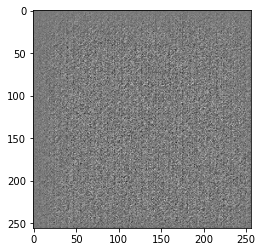

In [15]:
input_vec_len = 1024
generator = make_generator_model(input_vec_len)

# plot an image from the initialized generator model
noise = tf.random.normal([1, input_vec_len])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray');

In [16]:
# Get a model summary
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             67174400  
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTra  (None, 16, 16, 512)       13107200  
nspose)                                                          
_________________________________________________________________
batch_normalization (BatchN  (None, 16, 16, 512)       2048      
ormalization)                                                    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)       3

In [17]:
from tensorflow.keras import backend
from tensorflow.keras.layers import Layer

# mini-batch standard deviation layer
class MinibatchStdev(Layer):
  # initialize the layer
  def __init__(self, **kwargs):
    super(MinibatchStdev, self).__init__(**kwargs)

  # perform the operation
  def call(self, inputs):
    # calculate the mean value for each pixel across channels
    mean = backend.mean(inputs, axis=0, keepdims=True)
    # calculate the squared differences between pixel values and mean
    squ_diffs = backend.square(inputs - mean)
    # calculate the average of the squared differences (variance)
    mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
    # add a small value to avoid a blow-up when we calculate stdev
    mean_sq_diff += 1e-8
    # square root of the variance (stdev)
    stdev = backend.sqrt(mean_sq_diff)
    # calculate the mean standard deviation across each pixel coord
    mean_pix = backend.mean(stdev, keepdims=True)
    # scale this up to be the size of one input feature map for each sample
    shape = backend.shape(inputs)
    output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
    # concatenate with the output
    combined = backend.concatenate([inputs, output], axis=-1)
    return combined

  # define the output shape of the layer
  def compute_output_shape(self, input_shape):
    # create a copy of the input shape as a list
    input_shape = list(input_shape)
    # add one to the channel dimension (assume channels-last)
    input_shape[-1] += 1
    # convert list to a tuple
    return tuple(input_shape)

In [18]:
def make_discriminator_model():
  initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=55)

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5),
                          strides=(2, 2),
                          padding='same',
                          kernel_initializer=initializer,
                          use_bias=False,
                          input_shape=[IM_SIZE[0], IM_SIZE[1], 1]))
  model.add(layers.BatchNormalization(momentum=0.1,
                                    epsilon=0.8,
                                    center=1.0,
                                    scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  #model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5),
                          strides=(2, 2),
                          padding='same',
                          kernel_initializer=initializer,
                          use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1,
                                  epsilon=0.8,
                                  center=1.0,
                                  scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  #model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, (5, 5),
                          strides=(2, 2),
                          padding='same',
                          kernel_initializer=initializer,
                          use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1,
                                  epsilon=0.8,
                                  center=1.0,
                                  scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  #model.add(layers.Dropout(0.3))
  #model.add(layers.MaxPooling2D(padding='same'))

  model.add(layers.Conv2D(512, (5, 5),
                          strides=(2, 2),
                          padding='same',
                          kernel_initializer=initializer,
                          use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1,
                                  epsilon=0.8,
                                  center=1.0,
                                  scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  #model.add(layers.Dropout(0.3))

  model.add(MinibatchStdev())

  model.add(layers.Conv2D(1024, (5, 5),
                          strides=(2, 2),
                          padding='same',
                          kernel_initializer=initializer))
  model.add(layers.BatchNormalization(momentum=0.1,
                                    epsilon=0.8,
                                    center=1.0,
                                    scale=0.02))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [19]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49999416]], shape=(1, 1), dtype=float32)


In [20]:
# get a discriminator model summary
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1600      
_________________________________________________________________
batch_normalization_5 (Batc  (None, 128, 128, 64)      256       
hNormalization)                                                  
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       204800    
_________________________________________________________________
batch_normalization_6 (Batc  (None, 64, 64, 128)       512       
hNormalization)                                                  
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 128)      

In [21]:
# helper function for computing the cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [23]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
# save checkpoints
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
# define the training loop
EPOCHS = 500
noise_dim = 1024
num_examples_to_generate = 16

# set the random seed
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
# data augmentation helper function
def augment_batch(image_batch):
  data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation((-0.5, 0.5)),
  ])

  augmented_batch = data_augmentation(image_batch)
  return augmented_batch

In [28]:
# training loop
@tf.function
def train_step(images, batch_size, noise_dim):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                discriminator.trainable_variables))

In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice 'training' is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [30]:
def train(dataset, epochs):

  # load weights from checkpoints
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
  #generator.load_weights(checkpoint_path)
  #discriminator.load_weights(checkpoint_path)

  for epoch in range(epochs):
    start = time.time()

    # augment batches
    for image_batch in dataset:
      augmented_batch = augment_batch(image_batch)
      train_step(augmented_batch, BATCH_SIZE, noise_dim)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

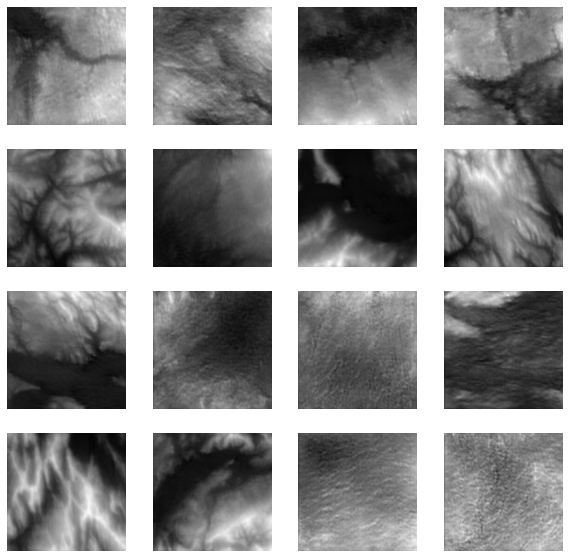

UnknownError: Failed to WriteFile: training_checkpoints\ckpt-19_temp/part-00000-of-00001.data-00000-of-00001.tempstate13013205107819325692 : There is not enough space on the disk.
; operation in progress [Op:SaveV2]

In [31]:
checkpoint_path = checkpoint_dir + "/ckpt-18"
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
train(train_dataset, EPOCHS)

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
noise = tf.random.normal([1, input_vec_len])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray');
#plt.savefig("test.jpg")
tensor_to_image(generated_image[0, :, :, 0]).save("test.png")